In [2]:
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
text_embedder = CohereTextEmbedder(model="embed-multilingual-light-v3.0")

In [3]:
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever

document_store = PineconeDocumentStore(
  index="prototype",
  metric="cosine",
  dimension=384,
  spec={"serverless": {"region": "us-east-1", "cloud": "aws"}},
  )

retriever = PineconeEmbeddingRetriever(document_store=document_store)


/Users/bobbybidon/git/rag-advisor/.conda/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

In [5]:
# from haystack.components.generators import OpenAIGenerator
# generator = OpenAIGenerator(model="gpt-3.5-turbo")

from haystack_integrations.components.generators.anthropic import AnthropicGenerator
generator =  AnthropicGenerator(model="claude-3-haiku-20240307")

# from haystack_integrations.components.generators.cohere import CohereGenerator
# generator = CohereGenerator(model="command-light")

In [6]:
from haystack_integrations.components.rankers.cohere import CohereRanker
ranker = CohereRanker(model="rerank-multilingual-v3.0")

In [7]:
from haystack import Pipeline

rag_pipeline = Pipeline()

rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component(instance=ranker, name="ranker")
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "ranker.documents")
rag_pipeline.connect("ranker", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")


🚅 Components
  - text_embedder: CohereTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - ranker: CohereRanker
  - prompt_builder: PromptBuilder
  - llm: AnthropicGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [10]:
question = "considérations pour choisir de bon écouteurs"

response = rag_pipeline.run({"text_embedder": {"text": question}, 
                            "prompt_builder": {"question": question},
                            "retriever": {"top_k": 3},
                            "ranker": {"query": question,
                                       "top_k": 2},
                            })

print(response["llm"]["replies"][0])


Voici les principales considérations à prendre en compte pour choisir de bons écouteurs :

1. Le type d'écouteurs :
   - Écouteurs-boutons (intra-auriculaires) : petits et légers, moins coûteux mais qualité sonore généralement inférieure.
   - Écouteurs "pods" : taille intermédiaire, plus confortables que les écouteurs-boutons.
   - Casques d'écoute : meilleure qualité sonore, mais plus encombrants et souvent plus chers.

2. Le contexte d'utilisation :
   - Utilisateur nomade : besoin d'écouteurs pliables, autonomie de batterie élevée, système de réduction de bruit, possibilité de passer des appels.
   - Utilisateur sédentaire : besoin d'écouteurs confortables pour des sessions d'écoute prolongées, qualité sonore et isolation phonique importantes.

3. Présence d'un système actif de réduction de bruit.
4. Confort et design des écouteurs.
5. Fonctionnalités offertes (commandes, prise en charge des appels, etc.).
6. Disponibilité des pièces de rechange.
7. Budget disponible.

En fonction 

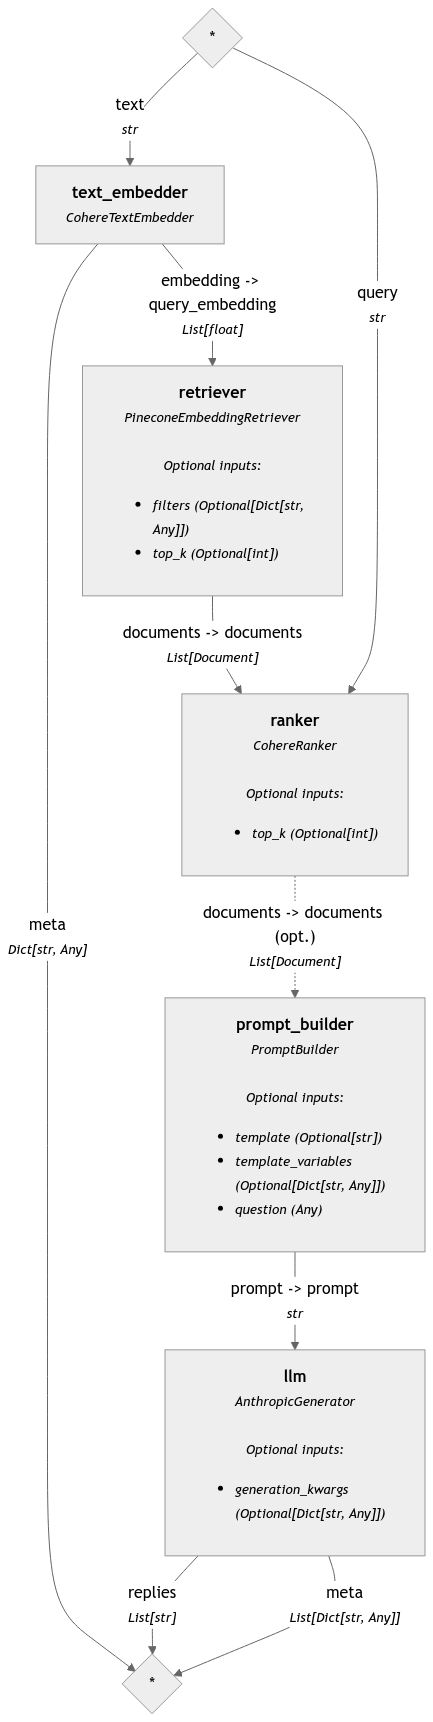

In [11]:
rag_pipeline.show()